In [13]:
import networkx as nx
import numpy as np
import scipy as sp
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, fsolve
from scipy.spatial.transform import Rotation
from scipy.spatial.distance import cdist

from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

import craterdetection.common.constants as const
from craterdetection.common.camera import Camera
from craterdetection.common.coordinates import nadir_attitude, ENU_system
from craterdetection.matching.database import extract_robbins_dataset, load_craters, CraterDatabase
from craterdetection.matching.projective_invariants import crater_representation, CoplanarInvariants, scale_det
from craterdetection.matching.utils import cyclic_permutations, enhanced_pattern_shifting, is_clockwise, all_clockwise, \
    np_swap_columns, is_colinear, cw_or_ccw, get_cliques_by_length
from craterdetection.common.conics import *



In [2]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 10], ellipse_limit=1.1)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [119]:
# Camera parameters can be derived from RNG
cam_lat, cam_long = map(np.radians, (25., 25.))
cam_alt = 250

cam = Camera.from_coordinates(cam_lat, cam_long, cam_alt, resolution=(256, 256))

cam.T = (Rotation.from_matrix(cam.T) * Rotation.from_euler('x', 0, degrees=True)).as_matrix()

dist = cam_alt / np.cos(np.radians(cam.fov/2)*np.sqrt(2)*1.0)
vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
r_craters = r_craters_cat[vicinity]
C_craters = C_craters_cat[vicinity]
A_craters = cam.project_crater_conics(C_craters, r_craters)

crater_centers = cam.project_crater_centers(r_craters)

C:\dev\workspace\crater-detection\craterdetection\common\conics.py:150: UserWarning: No contour levels were found within the data range.
  ax.contour(x_plot, y_plot, c.reshape(x_plot.shape), [0], colors=rim_color)


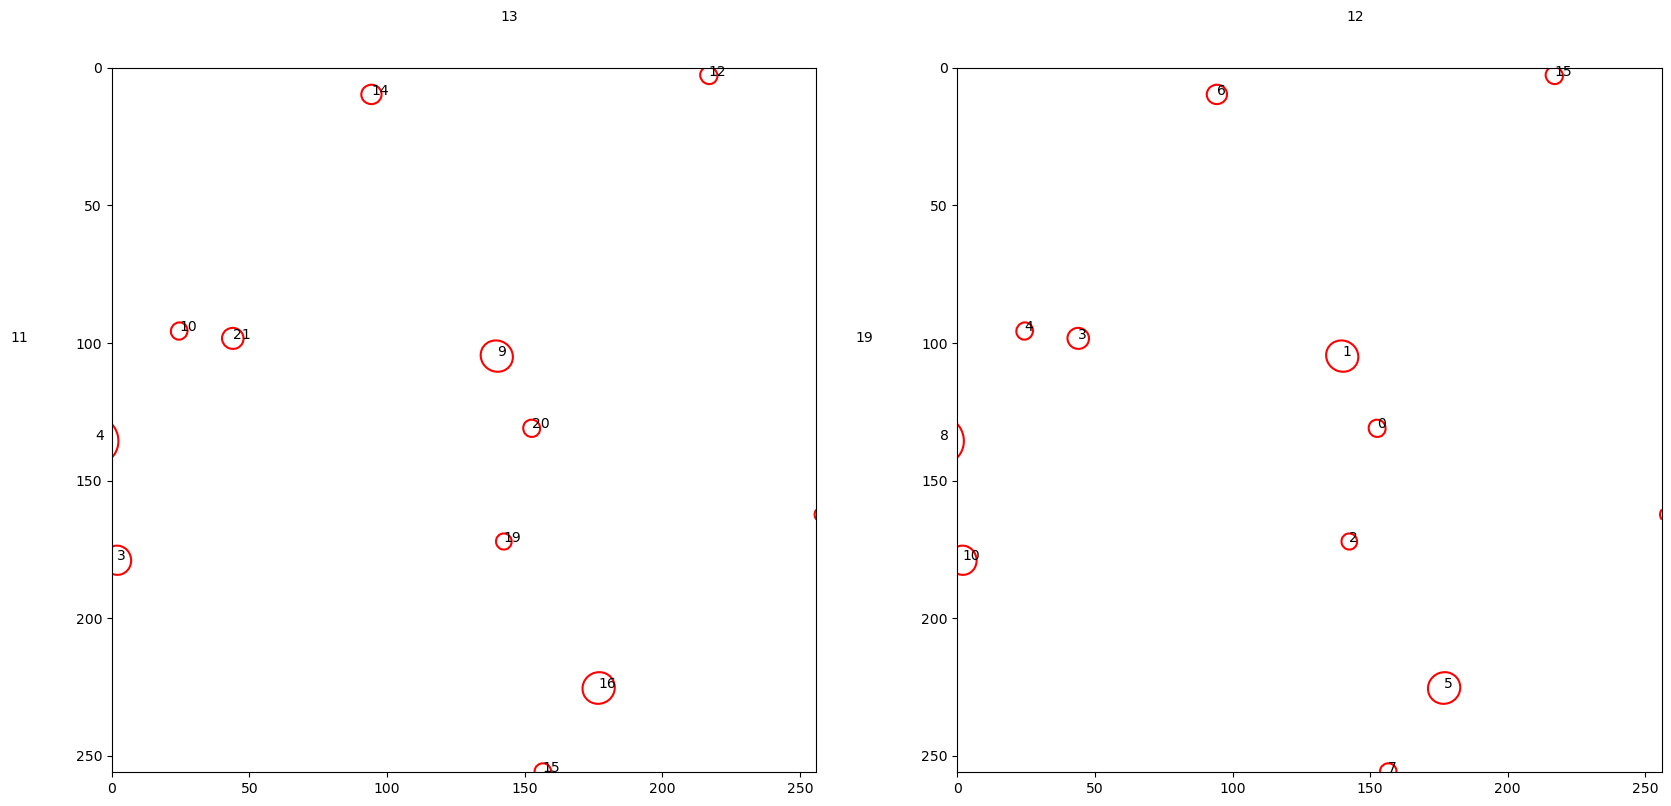

In [120]:
plt.style.use('default')

fig, axes = plt.subplots(1, 2, figsize=(20, 40), subplot_kw={'aspect': 'equal'})

plot_conics(A_craters, resolution=cam.resolution, plot_centers=True, ax=axes[0])
detection_order = np.argsort(cdist(crater_centers, np.array(cam.resolution)[None, :]/2).squeeze())

plot_conics(A_craters[detection_order], resolution=cam.resolution, plot_centers=True, ax=axes[1])

In [121]:
%%time
detection_graph = nx.minimum_spanning_tree(nx.from_numpy_matrix(cdist(crater_centers, crater_centers)))

Wall time: 2 ms


In [122]:
db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 10], latlims=[15, 35], longlims=[15, 35], radius=100)
# db = CraterDatabase(lat_cat[vicinity], long_cat[vicinity], major_cat[vicinity], minor_cat[vicinity], psi_cat[vicinity], radius=500)

In [123]:
np.set_printoptions(precision=3)
max_diff = 0.02
correct_matches = {detection_key : [] for detection_key, _ in enumerate(A_craters[detection_order])}
max_iter = 1e1

for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters[detection_order])):
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)

        diff = np.mean(np.abs(((db.features - features[order_full])/features[order_full])), axis=1)

        if np.min(diff) < max_diff:
            min_idx = np.argwhere(diff <= max_diff)

            subset_match = np.logical_and.reduce(lat_cat[vicinity][detection_order][crater_triad[order]] \
                                                                             == db.get_position(min_idx)[0].T, axis=2)
            if np.logical_or.reduce(subset_match):
                print(f"MATCH [{i}]")
                match = min_idx[np.where(subset_match)].item()
                print(crater_triad)
                print(order_full)

                rank = np.where(np.sort(diff) == diff[match])[0].item()
                print(f"\tMean difference: {diff[match]:.2%}, position: "
                      f"{rank}")

                print("\tDetection feature: \t", features[order_full])
                print("\tDB match feature: \t", db.features[match])

                print("\tCrater triad coords: \t",
                      lat_cat[vicinity][detection_order][crater_triad[order]],
                      long_cat[vicinity][detection_order][crater_triad[order]])
                print("\tDB match coords: \t", *db.get_position(match))
                for detection_idx, db_idx in zip(crater_triad[order], db.crater_triads[match]):
                    correct_matches[detection_idx] += [db_idx]
                print()
                break

    if i >= max_iter:
        break


MATCH [0]
[0 1 2]
[ 1  2  0  4  5  3 -1]
	Mean difference: 0.04%, position: 0
	Detection feature: 	 [-201.997 -192.71   -51.633 -339.386 -180.307  -33.289 -977.286]
	DB match feature: 	 [-201.814 -192.686  -51.637 -339.279 -180.247  -33.279 -976.773]
	Crater triad coords: 	 [0.447 0.416 0.435] [0.442 0.444 0.449]
	DB match coords: 	 [0.447 0.416 0.435] [0.442 0.444 0.449]



In [124]:
np.set_printoptions(precision=3)
max_diff = 0.02
correct_matches = {detection_key : [] for detection_key, _ in enumerate(A_craters[detection_order])}
max_iter = 1e2

for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters[detection_order])):
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)

        diff = np.mean(np.abs(((db.features - features[order_full])/features[order_full])), axis=1)

        if np.min(diff) < max_diff:
            min_idx = np.argmin(diff)

            for detection_idx, db_idx in zip(crater_triad[order], db.crater_triads[min_idx]):
                correct_matches[detection_idx] += [db_idx]
            break

    if i >= max_iter:
        break

In [125]:
for k, v in correct_matches.items():
    if len(v) >= 2:
        print(k, v)

0 [293, 293]
1 [137, 137]
3 [294, 294, 294, 294]
4 [138, 138, 138]
13 [289, 289, 289, 289]
14 [109, 109, 109, 109]
16 [113, 113, 113, 113]
17 [136, 136, 136, 136, 136, 136]
18 [135, 135, 135, 135]
20 [133, 133, 133]
21 [108, 108]


In [126]:
def vectorize(arr):
    return arr.reshape(-1, np.multiply(*arr.shape[-2:]), 1)

def derive_position(A_craters, r_craters, T_CM, K, qr=True, r_0=np.array([1, 1, 1]), **lsq_kwargs):
    A_craters = scale_det(A_craters)
    k = np.array([0., 0., 1.])[:, None]
    S = np.concatenate((np.identity(2), np.zeros((1, 2))), axis=0)

    B_craters = T_CM @ K.T @ A_craters @ K @ LA.inv(T_CM)
    T_EM = np.concatenate(ENU_system(r_craters), axis=-1)
    T_ME = LA.inv(T_EM)

    scale_i = vectorize(S.T @ C_craters @ S).transpose(0, 2, 1) @ vectorize(S.T @ T_ME @ B_craters @ T_EM @ S) \
            / (vectorize(S.T @ C_craters @ S).transpose(0, 2, 1) @ vectorize(S.T @ C_craters @ S))

    A = (S.T @ T_ME @ B_craters).reshape(-1, 3)
    b = (S.T @ T_ME @ B_craters @ r_craters - scale_i * S.T @ C_craters @ k).reshape(-1, 1)

    if qr:
        Q, R = LA.qr(linsys_A)
        Qb = np.dot(Q.T, linsys_B)
        return LA.solve(R, Qb)
    else:
        def position_system(r_M):
            return np.mean(A @ r_M[:, None] - b, axis=1).squeeze()

        opt = least_squares(position_system, r_0, **lsq_kwargs)
        return opt.x

In [127]:
%%time
est_pos = derive_position(A_craters[1], r_craters[1], cam.T, cam.K(), ftol=1e-12, xtol=1e-12)
print(f"Position error: {LA.norm(cam.r.ravel() - est_pos.ravel()):.2f} km")

Position error: 145.53 km
Wall time: 1e+03 µs


In [128]:
A_craters = scale_det(A_craters)
k = np.array([0., 0., 1.])[:, None]
S = np.concatenate((np.identity(2), np.zeros((1, 2))), axis=0)

B_craters = cam.T @ cam.K().T @ A_craters @ cam.K() @ LA.inv(cam.T)
T_EM = np.concatenate(ENU_system(r_craters), axis=-1)
T_ME = LA.inv(T_EM)

scale_i = vectorize(S.T @ C_craters @ S).transpose(0, 2, 1) @ vectorize(S.T @ T_ME @ B_craters @ T_EM @ S) \
        / (vectorize(S.T @ C_craters @ S).transpose(0, 2, 1) @ vectorize(S.T @ C_craters @ S))

linsys_A = (S.T @ T_ME @ B_craters).reshape(-1, 3)
linsys_B = (S.T @ T_ME @ B_craters @ r_craters - scale_i * S.T @ C_craters @ k).reshape(-1, 1)